In [169]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
import skvideo.io
from scipy.ndimage import affine_transform

import os
os.makedirs("../out", exist_ok=True)

# Q4: Extra Credit

# Use this notebook for question 4. 

# Using OpenCV to read the source video file frame by frame and converting to numpy array (4 dimensional) [T, H, W, C] where T - number of frames, H - height, W - Width of the frame an C - Number of channels (color channel = 3)

In [170]:
import cv2

file = "./usainbolt.mp4"
cap = cv2.VideoCapture(file)
if not cap.isOpened():
    print("Error openening video stream")

frames = []
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frames.append(frame)
cap.release()
frames = np.array(frames)
# Saving the vidoe frames and the zeroth frame
np.save("../data/usainbolt.npy", frames)
np.save("../data/usainboltframe0.npy", frames[0, :, :, :])

# Displaying the first frame of the video and the initial template rect

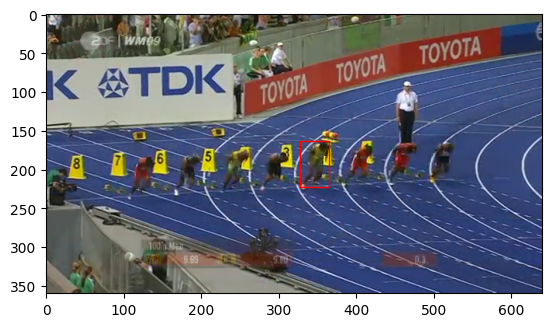

In [171]:
It0 = np.load("../data/usainboltframe0.npy")
# saving the first frame as png for reference purposes
cv2.imwrite("../data/usainbolt.png", It0)
# since OpenCV follows BGR format we need to convert to RGB to show on plt
It0 = cv2.cvtColor(It0, cv2.COLOR_BGR2RGB) 

rect = [327, 163, 365, 223]
w = rect[2] - rect[0]
h = rect[3] - rect[1]
plt.figure()
currentAxis = plt.gca()
rect_draw_It1 = patches.Rectangle((rect[0], rect[1]), w, h, linewidth=1, edgecolor='r', facecolor='none')
currentAxis.add_patch(rect_draw_It1)
plt.imshow(It0)
plt.show()

# Using Vanilla LK algorithm with translational warp

In [172]:
from scipy.interpolate import RectBivariateSpline



def LucasKanade(It, It1, rect, threshold, num_iters, p0=np.zeros(2)):
    """
    :param[np.array(H, W)] It   : Image frame at time-step t
    :param[np.array(H, W)] It1  : Image frame at time-step t+1
    :param[np.array(4, 1)] rect : Coordinates of template which has the form [x1, y1, x2, y2], where
                                  [x1, y1] is the top-left, and [x2, y2] is the bottom-right corner.  
    :param[float] dp_thresh     : If the length of dp < threshold, terminate the optimization
    :param[int] num_iters       : Number of iterations for running the optimization
    :param[np.array(2, 1)] p0   : Initial movement vector [dp_x0, dp_y0]

    :return[np.array(2, 1)] p   : Final movement vector [dp_x, dp_y]
    """
    # Initialize p to p0. Don't remove these lines.
    p = p0
    def threshcheck(pval):
        return np.linalg.norm(pval, ord=2)**2 < threshold

    x1, y1, x2, y2 = rect
    Ityvals, Itxvals = np.arange(It.shape[0]), np.arange(It.shape[1])
    It1yvals, It1xvals = np.arange(It1.shape[0]), np.arange(It1.shape[1])
    Itfn = RectBivariateSpline(Ityvals, Itxvals, It)
    It1fn = RectBivariateSpline(It1yvals, It1xvals, It1)

    x = np.arange(x1, x2 + 1)
    y = np.arange(y1, y2 + 1)

    x, y = np.meshgrid(x, y)
    x = x.flatten()
    y = y.flatten()
    # x, y coords of template needs to be converted to follow numpy convention

    template = Itfn.ev(y, x)[:, np.newaxis] 
    for _ in range(num_iters):
        # warp the image
        xhat = x + p[0]
        yhat = y + p[1]

        # It1 gradients along x and y
        Ix = It1fn.ev(yhat, xhat, dy=1, dx=0)[:, np.newaxis] # scipy x, y axis is normal convention
        Iy = It1fn.ev(yhat, xhat, dy=0, dx=1)[:, np.newaxis]
        
        # build the A matrix
        A = np.hstack((Ix, Iy))

        # build the b vector
        It1template = It1fn.ev(yhat, xhat)[:, np.newaxis]
        b = template - It1template
        
        # solve linear system of equations
        dp = np.linalg.lstsq(A, b, rcond=None)[0].squeeze(axis=1)
        p = p + dp
        if threshcheck(dp):
            break
    return p

# Tracking Sequence for 3 color channels. 

In [173]:
def TrackSequence(seq, rect, num_iters, lk_threshold, drift_threshold=2):
    """
    :param[np.array(T, H, W, C)] seq : sequence of frames
    :param[np.array(4, 1)] rect   : Coordinates of template which has the form [x1, y1, x2, y2], where
                                    [x1, y1] is the top-left, and [x2, y2] is the bottom-right corner.  
    :param[int] num_iters         : Number of iterations for running the optimization
    :param[float] dp_thresh       : If the length of dp < threshold, terminate the optimization
    :param[float] drift_threshold : float, threshold for the template update.

    :return[np.array(N, 4)] rects : Coordinates for the template at each frame in the sequence.
    """
    N, H, W, C = seq.shape
    rect_0 = np.copy(rect)
    rects =[rect]
    It0 = seq[0, :, :, :]
    for i in tqdm(range(1, seq.shape[0])):
        It = seq[i - 1, :, :, :]
        It1 = seq[i, :, :, :]
        p = np.zeros(2)
        pstar = np.zeros(2)
        # For each color channel LK is applied
        for channel in range(3):
            pc = LucasKanade(It[:, :, channel], It1[:, :, channel], rect, lk_threshold, num_iters)
            p0 = np.array([rect[0] + pc[0] - rect_0[0], rect[1] + pc[1] - rect_0[1]])
            pstar = LucasKanade(It0[:, :, channel], It1[:, :, channel], rect_0, lk_threshold, num_iters, p0=p0)
            p += pc
            pstar += pstar
        # Calculating avg. translation across color channels
        p = p / 3.0
        pstar = pstar / 3.0
        if np.linalg.norm(pstar - p, ord=2) <= drift_threshold:
            # drift didn't happen update template
            rect = [rect[0] + p[0], rect[1] + p[1], rect[2] + p[0], rect[3] + p[1]]
        else:
            # drift happened
            rect = [rect_0[0] + pstar[0], rect_0[1] + pstar[1], rect_0[2] + pstar[0], rect_0[3] + pstar[1]]

        rects.append(rect)

    rects = np.array(rects)
    return rects

# Processing the saved numpy array of frames and saving the calculated rects

In [174]:
seq = np.load("../data/usainbolt.npy")

rect = [327, 163, 365, 223]

num_iters = int(1e4)
threshold = 1e-1

rects = TrackSequence(seq, rect, num_iters, threshold)
np.save(f'../out/usainboltrects.npy', rects)

100%|██████████| 244/244 [00:37<00:00,  6.44it/s]


# Using OpenCV to draw the bounding box in the frame and saving the final video

In [175]:
seq = np.load("../data/usainbolt.npy")
usainboltrects = np.load("../out/usainboltrects.npy")
writer = skvideo.io.FFmpegWriter(
        "../out/usainbolt.mp4", outputdict={"-pix_fmt": "yuv420p"})
for idx in range(seq.shape[0]):
    frame = seq[idx, :, :, :]
    rect = usainboltrects[idx]
    w = rect[2] - rect[0]
    h = rect[3] - rect[1]
    cv2.rectangle(
        frame,
        (int(rect[0]), int(rect[1])),
        (int(rect[2]), int(rect[3])),
        (255.0, 0.0, 0.0),
        2,
    )
    writer.writeFrame(frame[..., ::-1])
writer.close()